<a href="https://colab.research.google.com/github/Tobai24/CXR-Pneumonia-Classifier/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import cv2 as cv

### Load the dataset from kaggle

In [2]:
!pip install kaggle


In [3]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:17<00:00, 232MB/s]
100% 2.29G/2.29G [00:17<00:00, 144MB/s]


In [5]:
!unzip chest-xray-pneumonia.zip


Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

### Remove dodgy images

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import imghdr
import os

In [7]:
data_dir = '/content/chest_xray'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Issue with image /content/chest_xray/test/NORMAL
Issue with image /content/chest_xray/test/PNEUMONIA
Issue with image /content/chest_xray/train/NORMAL
Issue with image /content/chest_xray/train/PNEUMONIA
Issue with image /content/chest_xray/val/NORMAL
Issue with image /content/chest_xray/val/PNEUMONIA
Image not in ext list /content/chest_xray/__MACOSX/._chest_xray
Issue with image /content/chest_xray/__MACOSX/chest_xray
Image not in ext list /content/chest_xray/chest_xray/.DS_Store
Issue with image /content/chest_xray/chest_xray/test
Issue with image /content/chest_xray/chest_xray/train
Issue with image /content/chest_xray/chest_xray/val


### Load Data

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

# Define image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescale for test and validation sets (no augmentation)
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

# Display class indices for reference
print("Class Indices:", train_generator.class_indices)

# Check the shape of a sample batch
sample_batch = next(train_generator)
print("Sample Batch Shape:", sample_batch[0].shape, sample_batch[1].shape)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Class Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Sample Batch Shape: (32, 224, 224, 3) (32,)


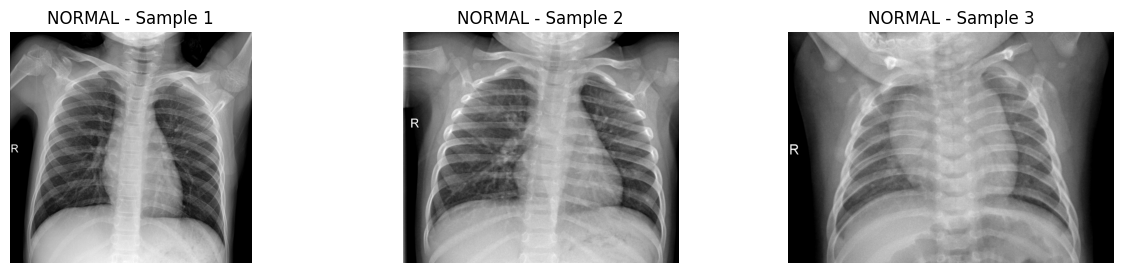

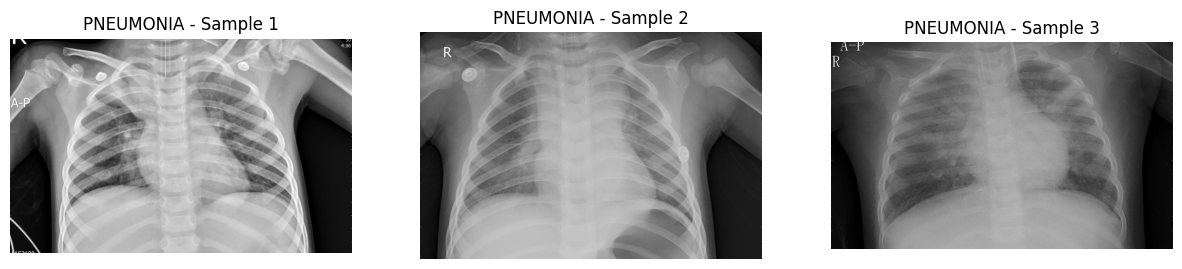

In [11]:
import random
import matplotlib.image as mpimg


# Function to display sample images
def display_samples(dataset_dir, class_name, num_samples=3):
    class_path = os.path.join(dataset_dir, class_name)
    img_files = random.sample(os.listdir(class_path), num_samples)

    plt.figure(figsize=(15, 3))
    for i, img_file in enumerate(img_files, 1):
        img_path = os.path.join(class_path, img_file)
        plt.subplot(1, num_samples, i)
        img = mpimg.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.title(f'{class_name} - Sample {i}')
        plt.axis('off')
    plt.show()

# Display samples from the training set
display_samples(train_dir, 'NORMAL')
display_samples(train_dir, 'PNEUMONIA')


### Deep Model
#### Build a deep learning model

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [13]:
model = Sequential()

In [14]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [15]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 16)        0

### Train the model

In [17]:
hist = model.fit(train_generator, epochs=20, validation_data=val_generator)

Epoch 1/20
163/163 [==============================] - 112s 619ms/step - loss: 0.3607 - accuracy: 0.8484 - val_loss: 0.3889 - val_accuracy: 0.8125
Epoch 2/20
163/163 [==============================] - 105s 647ms/step - loss: 0.2432 - accuracy: 0.8982 - val_loss: 0.3940 - val_accuracy: 0.8750
Epoch 3/20
163/163 [==============================] - 102s 624ms/step - loss: 0.2143 - accuracy: 0.9193 - val_loss: 0.2587 - val_accuracy: 0.8750
Epoch 4/20
163/163 [==============================] - 104s 639ms/step - loss: 0.1812 - accuracy: 0.9281 - val_loss: 1.4284 - val_accuracy: 0.6250
Epoch 5/20
163/163 [==============================] - 104s 639ms/step - loss: 0.1646 - accuracy: 0.9354 - val_loss: 1.3604 - val_accuracy: 0.6250
Epoch 6/20
163/163 [==============================] - 101s 621ms/step - loss: 0.1592 - accuracy: 0.9375 - val_loss: 0.5622 - val_accuracy: 0.8125
Epoch 7/20
163/163 [==============================] - 104s 640ms/step - loss: 0.1615 - accuracy: 0.9394 - val_loss: 0.5228 -

### Plot Performance

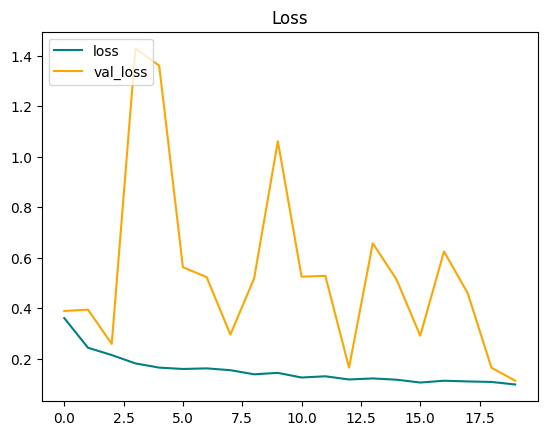

In [24]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.legend(loc="upper left")
plt.title('Loss')
plt.show()

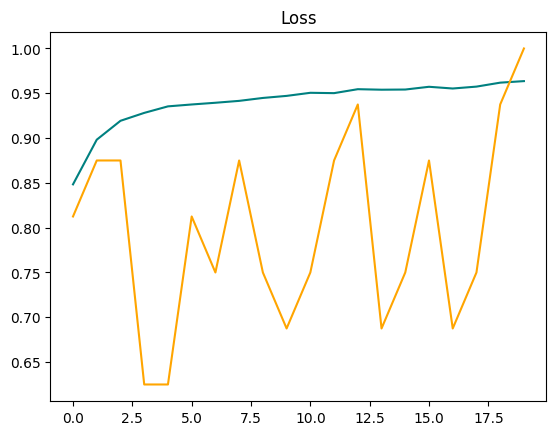

In [23]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Loss')
plt.show()

### Evaluate the model

In [35]:
# check the accuracy on test data
test_accuracy = model.evaluate(test_generator)

print(f'Test Accuracy: {test_accuracy[1]}')


20/20 [==============================] - 7s 348ms/step - loss: 0.3737 - accuracy: 0.9022
Test Accuracy: 0.9022436141967773


### Test the model

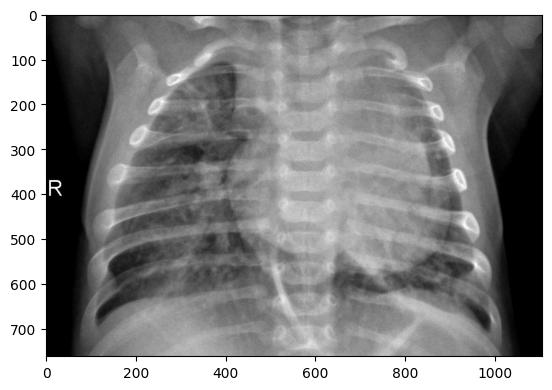

In [38]:
img = cv.imread("/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg")
plt.imshow(img)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

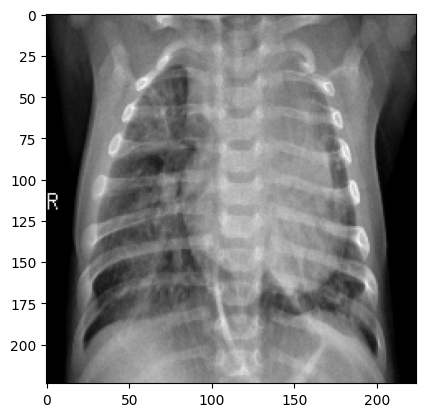

In [47]:
resize = tf.image.resize(img, (224, 224))
plt.imshow(resize.numpy().astype(int))
plt.show

In [48]:
yhat = model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 0s 18ms/step


In [49]:
if yhat > 0.5:
    print(f'X-ray with pneumonia')
else:
    print(f'A normal x-ray')

X-ray with pneumonia


#### Save model

In [45]:
from tensorflow.keras.models import load_model

In [51]:
model.save('/content/drive/MyDrive')